# Introduction
In this notebook, we'll build a ConvNet model to classify the images as either:
* Rs 1
* Rs 2
* Rs 5
* Reverse face of the coin
* Inavlid/fake coin

Note, this classification is in accordance to the classes present in the dataset.
# Setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

print('Tensorflow Version: ', tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow Version:  2.11.0


In [2]:
# Set path to the images folder

path = 'images/processed'

In [3]:
# Ensure reproducability across different runs of this program.

def set_seed(seed=2000): # set seed to an arbitrary integer.
    
    # Set seed value for the random number generators of Numpy and Tensorflow.
    # This is to ensure same sequence of random nos. are generated by numpy and Tensorflow
    # everytime this program is run.
    # Same seed value everytime leads to same set of random nos. generated everytime.
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    # Set environment variable 'PYTHONHASHSEED' to the seed value.
    # This is to ensure same hash codes are generated for accesing values with sets and
    # dictionaries irrespective of the order in which the values are accesed.
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Set environment variable 'TF_DETERMINISTIC_OPS' to 1.
    # This is to ensure same sequence of  are generated for accesing values with sets and
    # dictionaries irrespective of the order in which the values are accesed.
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Run the set_seed function to set the seed values and environment variables.
set_seed()

In [4]:
# Set Matplotlib defaults

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='medium',
       titleweight='bold', titlesize=13, titlepad=10,
      )
#warnings.filterwarnings("ignore") # to clean up output cells

# Create Training, Validation and Test Sets

In [5]:
# Parameters
image_size = [256, 256] # For resizing images. 256px X 256px is same as the size of the images in the datset.
val_test_split = 0.3 # Validation and test sets together take 30% of the data
batch_size=64 # No. of samples in each batch
seed=2000 # Seed value is a arbitary non-negative integer.

# train set
ds_train_ = image_dataset_from_directory(
    path, # The path to the dataset
    validation_split=val_test_split,
    subset='training',
    labels='inferred', # Labels infered from folder names
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest', # Algorithm used for resizing images.
    batch_size=batch_size,
    color_mode='grayscale', # color mode of images in the dataset.
    shuffle=True, # This will ensure shuffling of the set randomly before each epoch of training.
    seed=seed
)

# validation set
ds_valid_ = image_dataset_from_directory(
    path,
    validation_split=val_test_split,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True, # Validation set shouldn't be shuffled.
    seed=seed
)

# Get the number of batches available in the validation set.
val_batches = tf.data.experimental.cardinality(ds_valid_)

# Takeaway 50% of samples in ds_valid_ for test set.
ds_test_ = ds_valid_.take(val_batches // 2)
ds_valid_ = ds_valid_.skip(val_batches // 2)

# Get class names
class_names = ds_train_.class_names
print('Class names: ', class_names)

Found 1750 files belonging to 5 classes.
Using 1225 files for training.
Found 1750 files belonging to 5 classes.
Using 525 files for validation.
Class names:  ['1_rupee', '2_rupee', '5_rupee', 'invalid', 'reverse']


In [6]:
# Define a function to extract the labels from the test set
def get_labels(image, label):
    return label

# Extract the labels from the dataset
true_test_labels = ds_test_.map(get_labels)
true_test_labels = np.concatenate(list(true_test_labels.as_numpy_iterator()))
true_test_labels = np.argmax(true_test_labels, axis=1)

# Setup the Data Pipeline

In [9]:
# Convert the image tensor to float32 tensor 
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
# AUTOTUNE enables automatic tuning of prefetch buffer size dynamically during runtime
# Such a tuned buffer size ensures proper allocation of hardware resources for optimal performance.

ds_train = (
    ds_train_
    .map(convert_to_float) # Applies convert_to_float function to each image tensor
    .cache() # Caches the dataset in memory to improve performance during training.
    .prefetch(buffer_size=AUTOTUNE) # Prefetches dataset elements in the background during training.
                                    # buffer_size specifies max. no. of elements to prefetch.
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [12]:
print(ds_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


# Define the NN Model

In [8]:
model = keras.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=5,
                  activation="relu",
                  padding='same',
                  input_shape=[256, 256, 1]),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=5, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

# Compile, Build and Evaluate the Model

Epoch 1/50
20/20 [==============================] - 12s 309ms/step - loss: 1.5991 - accuracy: 0.2392 - val_loss: 1.5703 - val_accuracy: 0.2825
Epoch 2/50
20/20 [==============================] - 3s 156ms/step - loss: 1.5462 - accuracy: 0.3404 - val_loss: 1.4900 - val_accuracy: 0.3829
Epoch 3/50
20/20 [==============================] - 3s 155ms/step - loss: 1.4290 - accuracy: 0.4327 - val_loss: 1.4067 - val_accuracy: 0.3978
Epoch 4/50
20/20 [==============================] - 3s 154ms/step - loss: 1.2963 - accuracy: 0.4735 - val_loss: 1.2967 - val_accuracy: 0.4238
Epoch 5/50
20/20 [==============================] - 3s 155ms/step - loss: 1.1506 - accuracy: 0.5371 - val_loss: 1.0218 - val_accuracy: 0.6059
Epoch 6/50
20/20 [==============================] - 3s 157ms/step - loss: 0.9735 - accuracy: 0.6253 - val_loss: 0.9935 - val_accuracy: 0.5874
Epoch 7/50
20/20 [==============================] - 3s 156ms/step - loss: 0.8770 - accuracy: 0.6702 - val_loss: 0.8100 - val_accuracy: 0.6952
Epoch

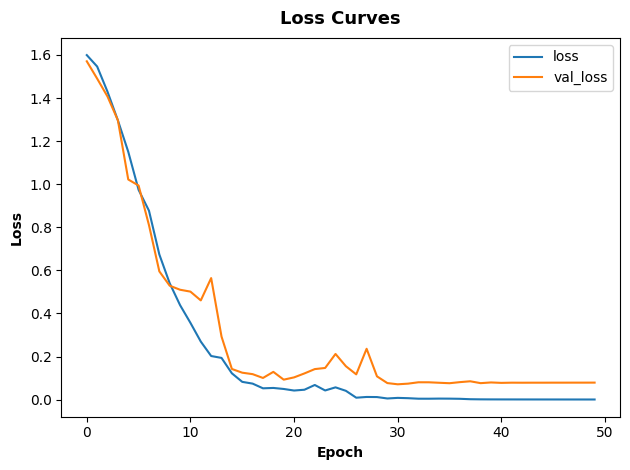

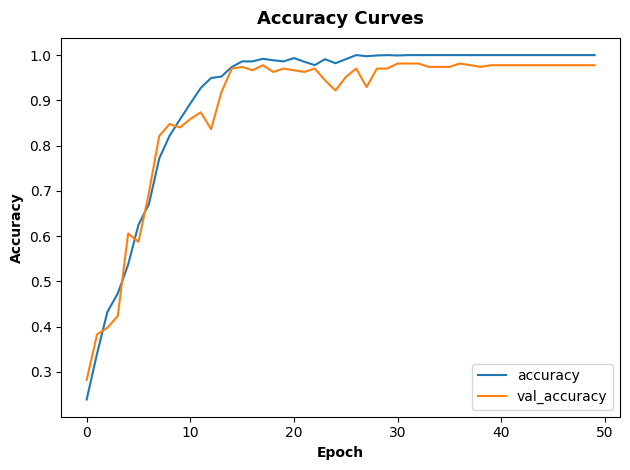

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50
)

# Evaluate the model on the test set
print('\nTest set Evaluation:\n')
test_loss, test_accuracy = model.evaluate(ds_test)
print('\n')

# Plot loss and accuracy curves
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model

In [10]:
model.save('model.h5')

# Make a Prediction

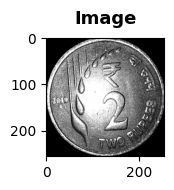

1/1 [==============================] - 0s 146ms/step
Prediction:  [[0. 1. 0. 0. 0.]]
Predicted class:  2_rupee


In [11]:
from PIL import Image

# Select a file from the dataset to predict
image_file_path = 'images/processed/2_rupee/IMG_20230501_200352912.jpg' 

# Get the image from the file.
image = Image.open(image_file_path)
image = image.convert('L') # Convert image to grayscale

# Plot the image
plt.figure(figsize=(2,2))
plt.imshow(image, 'gray')
plt.title('Image')
plt.show()

image_array = np.asarray(image) # convert PIL image to np.ndarray

# image_array has a shape of (256,256) but the prediction method of NN model requires an input
# shape of (w,x,y,z) where:
# w is batch size
# x and y are image dimentions
# z is the channel depth
# So we have to add an extra dimention at the begining and end of image_array
image_array = image_array[np.newaxis, :, :, np.newaxis]

preditcion = model.predict(image_array)
print('Prediction: ', preditcion)

predicted_class = np.argmax(preditcion)
print('Predicted class: ', class_names[predicted_class])

**Done**